In [1]:
ID = "101615093"

YOUR ANSWER HERE

### Table of Contents

* [Introduction](#introduction)
* [Section 1: Loading the Data](#section_1)
    * [Section 1.1: Grades Data](#section_1_1)
    * [Section 1.2: Activity Duration Data](#section_1_2)
    * [Section 1.3: Conversation Duration Data](#section_1_3)
* [Section 2: Preprocessing the Data](#section_2)
    * [Section 2.1: Preprocessing grades data](#section_2_1)
    * [Section 2.2: Preprocessing activity data](#section_2_2)
    * [Section 2.3: Preprocessing conversation data](#section_2_3)
* [Section 3: Exploration](#section_3)
    * [Section 3.1: Grades data exploration](#section_3_1)
    * [Section 3.2: Activity data exploration](#section_3_2)
    * [Section 3.3: Conversation data exploration](#section_3_3)
* [Section 4: Analysis](#section_4)
    * [Section 4.1: Merge dataframes](#section_4_1)        
    * [Section 4.2: Visualize data](#section_4_2)
        * [Section 4.2.1: GPA and Activity Duration](#section_4_2_1)
        * [Section 4.2.2: GPA and Conversation Duration](#section_4_2_2)
    * [Section 4.3: Regression Analysis](#section_4_3)
        * [Section 4.3.1: GPA vs Activity Duration](#section_4_3_1)
        * [Section 4.3.2: GPA vs Conversation Duration](#section_4_3_2)
* [Section 5: Interpretation](#section_5)
* [References](#references)
* [*Extra Reading](#extra)

---

# Section 1: Loading the Data <a class="anchor" id="section_1"></a>

In this section, we'll start by importing the Python modules required in this exercise and then import selected and prepared features from the StudentLife dataset. 

In [108]:
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# define data path
if 'AALTO_JUPYTERHUB' in os.environ:
    # using jupyter sharedata directory
    DATA = '/coursedata/pa1/'
else:
    DATA = './data/'


Then, we load data in three separate CSV files: 
1. Grades Data: Contains information about students' academic performance.
2. Conversation Duration Data: Captures the duration of conversations that students have had.
3. Activity Duration Data: Contains information about different physical activities that students engage in.

## Section 1.1: Grades Data <a class="anchor" id="section_1_1"></a>

First, we'll load the grades data and have a peek:

In [109]:
# Load GPA data
grades_df =  pd.read_csv(os.path.join(DATA, 'grades.csv'))
print("Grades data loaded!")
print(grades_df.head())

Grades data loaded!
   uid   gpa all   gpa 13s   cs 65
0  u01     2.863  1.777778     3.0
1  u02     3.505  4.000000     4.0
2  u04     3.029  3.500000     4.0
3  u05     3.679  3.777778     4.0
4  u07     3.474  4.000000     4.0


The dataframe has four columns:
- **uid** : user id
- **gpa all** : overall grade point average (gpa)
- **gpa 13s** : spring term 2013 gpa
- **cs 65** : a specific course-related info

## Section 1.2: Activity Duration Data <a class="anchor" id="section_1_2"></a>

Then, we'll load the activity duration data.

In [110]:
# Load activity data
activity_df = pd.read_csv(os.path.join(DATA, 'hourly_activity.csv'), index_col=0)

# Print dataframe head and first four columns
print("\nActivity data loaded!")
print(activity_df.iloc[:, :4].head())


Activity data loaded!
     2013-03-27 00:00:00-04:00  2013-03-27 01:00:00-04:00  \
id                                                          
u00                   0.000000                        0.0   
u01                   0.002941                        0.0   
u02                   0.024096                        0.0   
u03                   0.000000                        0.0   
u04                   0.000000                        0.0   

     2013-03-27 02:00:00-04:00  2013-03-27 03:00:00-04:00  
id                                                         
u00                   0.020173                        0.0  
u01                   0.000000                        0.0  
u02                   0.000000                        0.0  
u03                   0.000000                        0.0  
u04                   0.000000                        0.0  


The dataframe has the student id on the index column, and other columns show hourly timestamps and activity tracker inferred activity duration for each student during that hour (0 means no activity, 1 means that the student has been active for the whole hour). The data covers spring term 2013.

## Section 1.3: Conversation Duration Data <a class="anchor" id="section_1_3"></a>

And finally, the conversation duration data:

In [111]:
# Load the conversation data
conversation_df = pd.read_csv(os.path.join(DATA, 'conversation_durations.csv'), index_col=0)

# Print dataframe head
print("Conversation data loaded!")
print(conversation_df.head())

Conversation data loaded!
                   timestamp   id  duration
0  2013-03-27 00:00:00-04:00  u00  3.533333
1  2013-03-27 01:00:00-04:00  u00       NaN
2  2013-03-27 02:00:00-04:00  u00       NaN
3  2013-03-27 03:00:00-04:00  u00       NaN
4  2013-03-27 04:00:00-04:00  u00       NaN


The dataframe has three columns:
- **timestamp** : hourly timestamps covering spring term 2013
- **id** : student id
- **duration** : mobile phone inferred conversation duration during the hour (0-60 min).

We notice that the dataframes are of different formats. Thus, some transformations are needed to merge them. We'll do that in the next section.

---

# Section 2: Preprocessing the Data <a class="anchor" id="section_2"></a>

Data preprocessing is a crucial step in any data science or machine-learning workflow. In this section, we will clean the data, and select and transform certain features to prepare our data for the subsequent steps. We proceed with a dataframe at a time, starting with the grades.

## Section 2.1: Preprocessing grades data <a class="anchor" id="section_2_1"></a>

We'll start by checking the data with `describe()`:

In [112]:
grades_df.describe()

,gpa all,gpa 13s,cs 65
count,30.000000,30.000000,30.000000
mean,3.421533,3.330556,3.622222
std,0.397754,0.798284,0.796224
min,2.400000,1.000000,0.000000
25%,3.257000,3.333333,3.666667
50%,3.490500,3.527778,4.000000
75%,3.698500,3.861111,4.000000
max,3.947000,4.000000,4.000000


We notice that there are no apparent outliers in the data. Then we'll check if there are any missing values with chaining `isna()`and `sum()`: 

In [113]:
grades_df.isna().sum()

uid         0
 gpa all    0
 gpa 13s    0
 cs 65      0
dtype: int64

There are no missing values. Instead, we noted that the columns column names contain some unwanted empty spaces. Let's print the column names using `columns`: 

In [114]:
print(list(grades_df.columns))

['uid', ' gpa all', ' gpa 13s', ' cs 65']


In this exercise, we are only interested in spring term GPA, so we'll select only that column and student id's. 

&#x1F4DD; **Task:**
- Select only columns named "uid" and " gpa 13s", discarding the rest. Notice the empty spaces in strings.
- For the convenience, rename those columns "id" and "gpa".

In [115]:
# Select only required columns and rename them for the grades data

grades_df = grades_df[['uid', ' gpa 13s']].rename(columns={'uid': 'id', ' gpa 13s': 'gpa'})

print("Grades data after preprocessing:")
grades_df.head()

Grades data after preprocessing:


,id,gpa
0,u01,1.777778
1,u02,4.000000
2,u04,3.500000
3,u05,3.777778
4,u07,4.000000


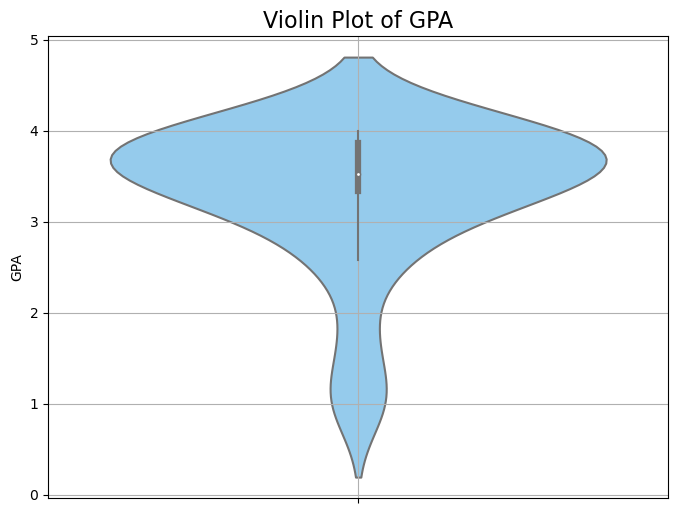

In [116]:
#MY PERSONAL VISUALIZATION
# Create a violin plot of the 'gpa' column
plt.figure(figsize=(8, 6))
sns.violinplot(data=grades_df, y='gpa', color='lightskyblue')

plt.title('Violin Plot of GPA', fontsize=16)
plt.ylabel('GPA')

plt.grid()
plt.show()

## Section 2.2: Preprocessing activity data <a class="anchor" id="section_2_2"></a>

Next, we'll inspect activity data. The data is organized so that each column represents a date and hour, and each row is a subject. We'll start by inspecting the data and checking missing values:


In [117]:
activity_df.describe()

,2013-03-27 00:00:00-04:00,2013-03-27 01:00:00-04:00,2013-03-27 02:00:00-04:00,2013-03-27 03:00:00-04:00,2013-03-27 04:00:00-04:00,2013-03-27 05:00:00-04:00,2013-03-27 06:00:00-04:00,2013-03-27 07:00:00-04:00,2013-03-27 08:00:00-04:00,2013-03-27 09:00:00-04:00,...,2013-05-31 14:00:00-04:00,2013-05-31 15:00:00-04:00,2013-05-31 16:00:00-04:00,2013-05-31 17:00:00-04:00,2013-05-31 18:00:00-04:00,2013-05-31 19:00:00-04:00,2013-05-31 20:00:00-04:00,2013-05-31 21:00:00-04:00,2013-05-31 22:00:00-04:00,2013-05-31 23:00:00-04:00
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,...,20.000000,20.000000,19.000000,17.000000,17.000000,17.000000,17.000000,18.000000,17.000000,17.000000
mean,0.015598,0.002914,0.005982,0.000160,0.000321,0.000241,0.002136,0.026822,0.080031,0.134705,...,0.177567,0.219467,0.235360,0.246162,0.192385,0.142220,0.158920,0.144353,0.102456,0.048155
std,0.052439,0.011319,0.028580,0.000864,0.001727,0.001299,0.011503,0.082057,0.127487,0.114919,...,0.304583,0.302078,0.294902,0.267952,0.307503,0.237510,0.209353,0.171112,0.176240,0.109214
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.044379,0.000000,0.008772,0.000000,0.006618,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.115385,...,0.000000,0.108205,0.160121,0.169184,0.056911,0.055718,0.031884,0.068324,0.000000,0.004451
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.160121,0.218563,...,0.196956,0.289475,0.342031,0.357860,0.229261,0.149733,0.263158,0.202006,0.178248,0.030395
max,0.251462,0.053731,0.153302,0.004651,0.009302,0.006993,0.061947,0.323899,0.458034,0.362500,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.944023,0.652174,0.573171,0.527950,0.427653


In [118]:
activity_df.isna().sum()

2013-03-27 00:00:00-04:00    20
2013-03-27 01:00:00-04:00    20
2013-03-27 02:00:00-04:00    20
2013-03-27 03:00:00-04:00    20
2013-03-27 04:00:00-04:00    20
                             ..
2013-05-31 19:00:00-04:00    32
2013-05-31 20:00:00-04:00    32
2013-05-31 21:00:00-04:00    31
2013-05-31 22:00:00-04:00    32
2013-05-31 23:00:00-04:00    32
Length: 1584, dtype: int64

We notice that there are no apparent outliers in the data, and columns have some missing values.

&#x1F4DD; **Task:**
- Fill nan's on `activity_df` with zero. We will use this dataframe for visualizations later.
- Create a new dataframe named `avg_activity_df` 
   - On that dataframe, calculate the average activity for each student ('id')
   - The dataframe should contain two columns:
       - **id** : with unique student id's
       - **duration** : average activity duration for each student ('id')

In [126]:
# Step 1: Fill NaN values in activity_df with zeros
activity_df.fillna(0, inplace=True)

# Step 2: Create avg_activity_df with the average activity duration for each student
avg_activity_df = activity_df.mean(axis=1).reset_index()
avg_activity_df.rename(columns={0: 'duration'}, inplace=True)

print("Number of missing values in activity_df:")
print(activity_df.isna().sum().sum())
print("Average hourly activity for each user:")
avg_activity_df.head()

Number of missing values in activity_df:
0
Average hourly activity for each user:


,id,duration
0,u00,0.117676
1,u01,0.072225
2,u02,0.081922
3,u03,0.012604
4,u04,0.122009


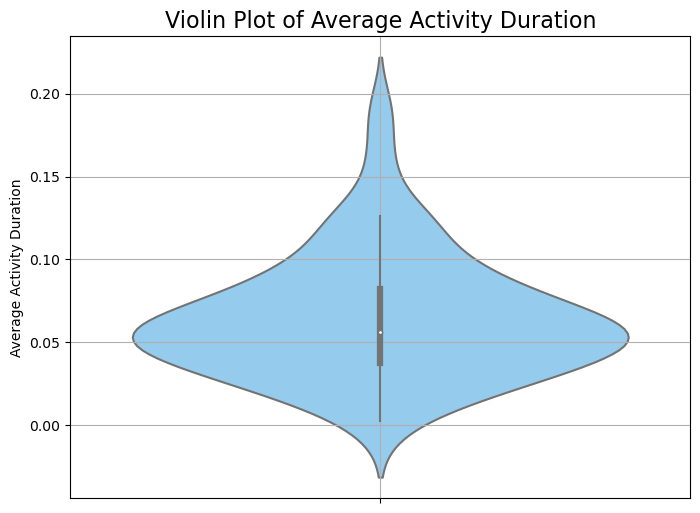

In [127]:
#MY PERSONAL VISUALIZATION
# Create a violin plot of the 'average_duration' values
plt.figure(figsize=(8, 6))
sns.violinplot(data=avg_activity_df, y='duration', color='lightskyblue')

plt.title('Violin Plot of Average Activity Duration', fontsize=16)
plt.ylabel('Average Activity Duration')
plt.grid()
plt.show()

In [ ]:
### Hidden tests



## Section 2.3: Preprocessing conversation data <a class="anchor" id="section_2_3"></a>

Again, we'll start by inspecting the data and checking missing values:


In [128]:
conversation_df.describe()

,duration
count,32263.000000
mean,25.013088
std,18.770282
min,0.016667
25%,7.716667
50%,21.366667
75%,41.283333
max,60.000000


In [129]:
conversation_df.isna().sum()

timestamp        0
id               0
duration     45451
dtype: int64

It appears that there are some missing values in the data. This time, those missing values are interpreted so that the subject is not engaged in conversation during the hour indicated by the index time stamp. Therefore, we do not remove these values but replace those with 0 (integer).
📝 Task:
Replace all NaN values on the "duration" column with 0.
- &#x1F4A1; You can use [`pandas.DataFrame.fillna`](https://pandas.pydata.org/docs/reference>/api/pandas.DataFrame.fillna.html)


In [130]:
# Fill missing durations with 0

# Replace NaN values in the "duration" column with 0
conversation_df['duration'].fillna(0, inplace=True)

In [39]:
conversation_df.isna().sum()

timestamp    0
id           0
duration     0
dtype: int64

In [ ]:
### Hidden tests


Next, let's set the "timestamp" column as a dataframe index and convert it into datetime-format.

&#x1F4DD; **Task:**
- Set column "timestamp" as index
-💡Use [`pandas.DataFrame.set_index`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.set_index.html)
- Convert index into datetime format
-💡Use [`pandas.to_datetime`](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html)

In [131]:
# Set "timestamp" column as the index
conversation_df.set_index('timestamp', inplace=True)

# Convert the index to datetime format
conversation_df.index = pd.to_datetime(conversation_df.index)

In [ ]:
### Hidden tests



In [132]:
conversation_df.head()

,id,duration
timestamp,,
2013-03-27 00:00:00-04:00,u00,3.533333
2013-03-27 01:00:00-04:00,u00,0.000000
2013-03-27 02:00:00-04:00,u00,0.000000
2013-03-27 03:00:00-04:00,u00,0.000000
2013-03-27 04:00:00-04:00,u00,0.000000


Next, we want to focus only on the conversation during morning hours (9 AM to 12 PM). We do that with the following function that you need to complete.

&#x1F4DD; **Task:**
- Start by examining the comments on a function below 
- From the original conversation_df dataframe, select only rows having timestamped hours `start_hour` and `end_hour`, given as function arguments (integers from 0 to 23).
- You can extract hour from [Pandas DatetimeIndex](https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html) by `.hour` attribute (e.g., df.index.hour)
- Use the selected rows to create a new dataframe called `avg_conversation_df` (the function should return this)
-💡While there are multiple ways of filtering the dataframe, you could try, for example [pandas.DataFrame.query](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.query.html) or [pandas.DataFrame.mask](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mask.html)
 

In [133]:
def filter_average_duration(df, start_hour, end_hour):
    """
    Calculate the average duration of events for each 'id', filtering by a specific time range.
    
    Parameters:
    - df (pandas.DataFrame): The DataFrame containing event data. 
                             It should have a datetime index and columns 'id' and 'duration'.
    - start_hour (int): The starting hour for the time range filter (24-hour format).
    - end_hour (int): The ending hour for the time range filter (24-hour format).
    
    Returns:
    pandas.DataFrame: A DataFrame containing each 'id' and its corresponding average 'duration'
                      for events that occur between 'start_hour' and 'end_hour'.
    """

    # Filter the DataFrame based on the specified time range
    filtered_df = df[(df.index.hour >= start_hour) & (df.index.hour <= end_hour)]

    # Calculate the average duration for each 'id'
    avg_conversation_df = filtered_df.groupby('id')['duration'].mean().reset_index()
    avg_conversation_df.rename(columns={'duration': 'duration'}, inplace=True)

    return avg_conversation_df


In [134]:
# Calculate the average conversation duration during daytime for each subject
avg_conversation_df = filter_average_duration(conversation_df,9,12)

print("Average conversation duration for each subject:")
avg_conversation_df.head()

Average conversation duration for each subject:


,id,duration
0,u00,24.576073
1,u01,13.368624
2,u02,16.726136
3,u03,4.972222
4,u04,24.844192


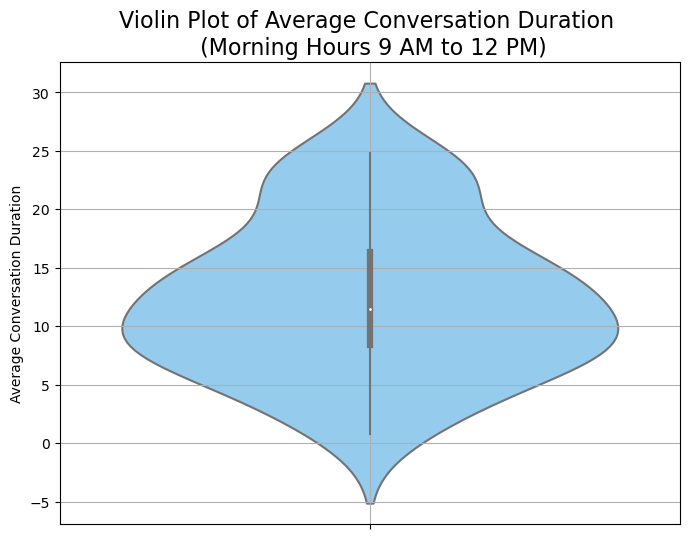

In [135]:
#MY PPERSONAL VISUALIZATION
# Create a violin plot of the 'average_duration' values
plt.figure(figsize=(8, 6))
sns.violinplot(data=avg_conversation_df, y='duration', color='lightskyblue')

plt.title('Violin Plot of Average Conversation Duration \n (Morning Hours 9 AM to 12 PM)', fontsize=16)
plt.ylabel('Average Conversation Duration')

plt.grid()
plt.show()

In [ ]:
### Hidden tests



---

# Section 3: Exploration <a class="anchor" id="section_3"></a>

Data exploration and visualization offer invaluable insights into the dataset's structure, quirks, and patterns. This section, we visualize data and hourly distributions for activity and conversation durations. 

## Section 3.1: Grades data exploration <a class="anchor" id="section_3_1"></a>

Let's start by inspecting the grades.

<Figure size 1200x600 with 0 Axes>

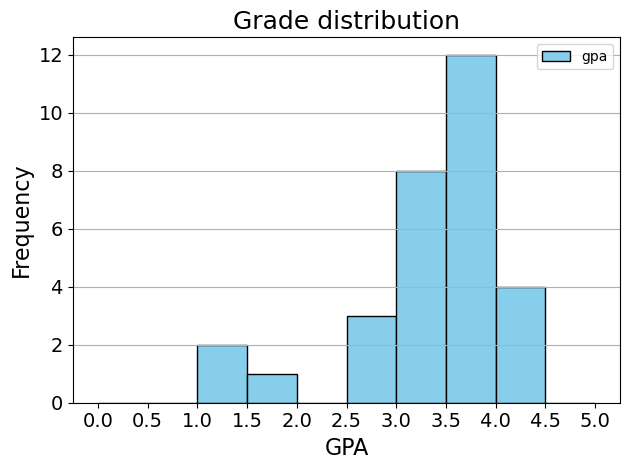

In [136]:
# define bins for the grades
bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

# Plot
plt.figure(figsize=(12, 6))
grades_df.plot(kind='hist', bins=bins, edgecolor="k", color='skyblue')
plt.title('Grade distribution', fontsize=18)
plt.xlabel('GPA', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(bins, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

We notice that while the GPA is generally quite good, there are few students with low scores.

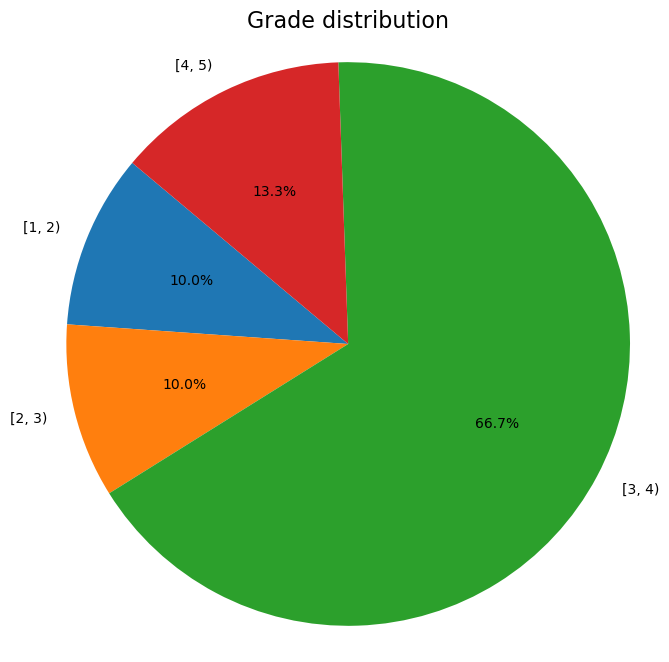

In [137]:
#MY PERSONAL VISUALIZATION
# Define the bins
bins = [1, 2, 3, 4, 5]

# Categorize the data into bins
grades_df['gpa_bin'] = pd.cut(grades_df['gpa'], bins=bins, include_lowest=True, right=False)

# Group by the bins and count the number of occurrences
grades_distribution = grades_df['gpa_bin'].value_counts().sort_index()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(grades_distribution, labels=grades_distribution.index, autopct='%1.1f%%', startangle=140)

plt.title('Grade distribution', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is drawn as a circle.

plt.show()

In [143]:
#Remove the "gpa_bin" column that I created for the pie chart
grades_df.drop('gpa_bin', axis=1, inplace=True)

## Section 3.2: Activity data exploration <a class="anchor" id="section_3_2"></a>

Next, we'll visualize students' average activity distribution.

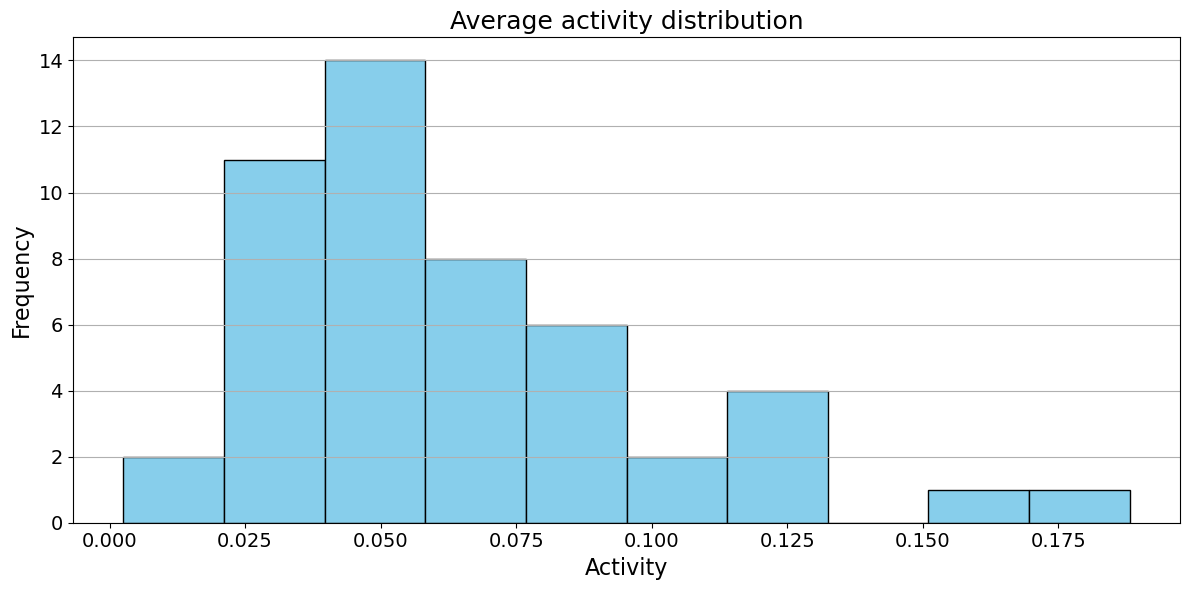

In [138]:
# Plot
plt.figure(figsize=(12, 6))
avg_activity_df['duration'].plot(kind="hist", edgecolor="k", color='skyblue')
plt.title('Average activity distribution', fontsize=18)
plt.xlabel('Activity',fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

We observe that the activity distribution is slightly right-skewed.
Next, we'll transform activity data, calculate hourly sums, and visualize the hourly activity.

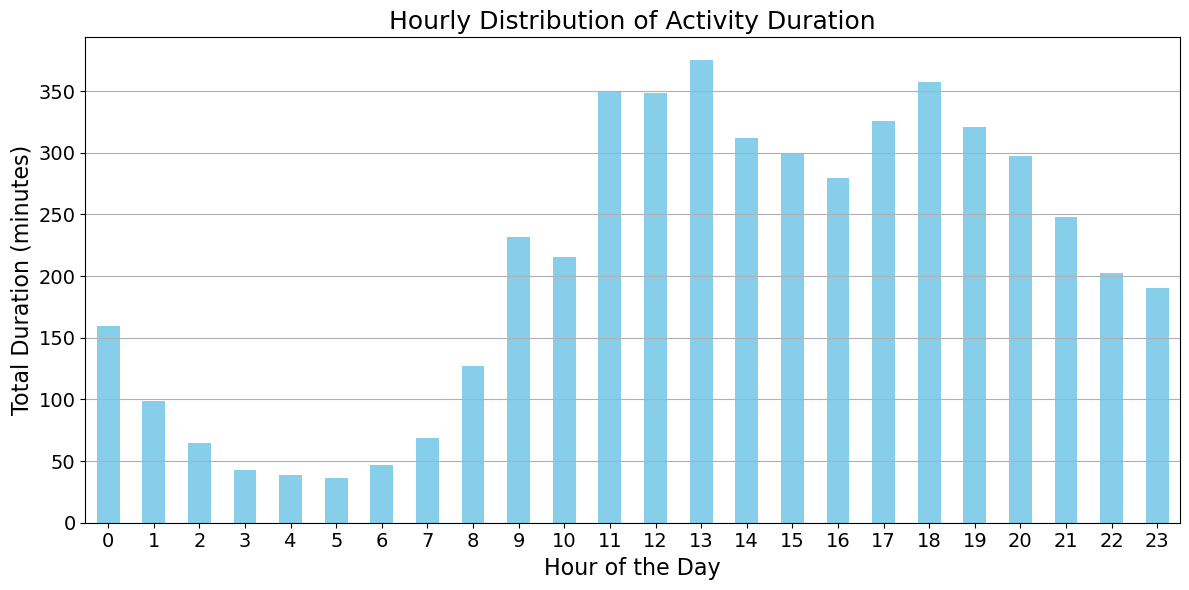

In [139]:
# Start by transposing the dataframe
activity_df = activity_df.T

# Convert the index to DateTime object
activity_df.index = pd.to_datetime(activity_df.index)

# Extract the hour and create a new column
activity_df['hour'] = activity_df.index.hour

# Group by the 'hour' column and sum the rows for each group
activity_hourly_distribution = activity_df.groupby('hour').sum().sum(axis=1)

# Plot
plt.figure(figsize=(12, 6))
activity_hourly_distribution.plot(kind='bar', color='skyblue')
plt.title('Hourly Distribution of Activity Duration', fontsize=18)
plt.xlabel('Hour of the Day', fontsize=16)
plt.ylabel('Total Duration (minutes)', fontsize=16)
plt.xticks(rotation=0,fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

Activity distribution looks reasonable, having two activity peaks during the day (around noon and 6 PM), and during the night, activity is at the lowest.

## Section 3.3: Conversation data exploration <a class="anchor" id="section_3_3"></a>

Next, we'll visualize the conversation data.

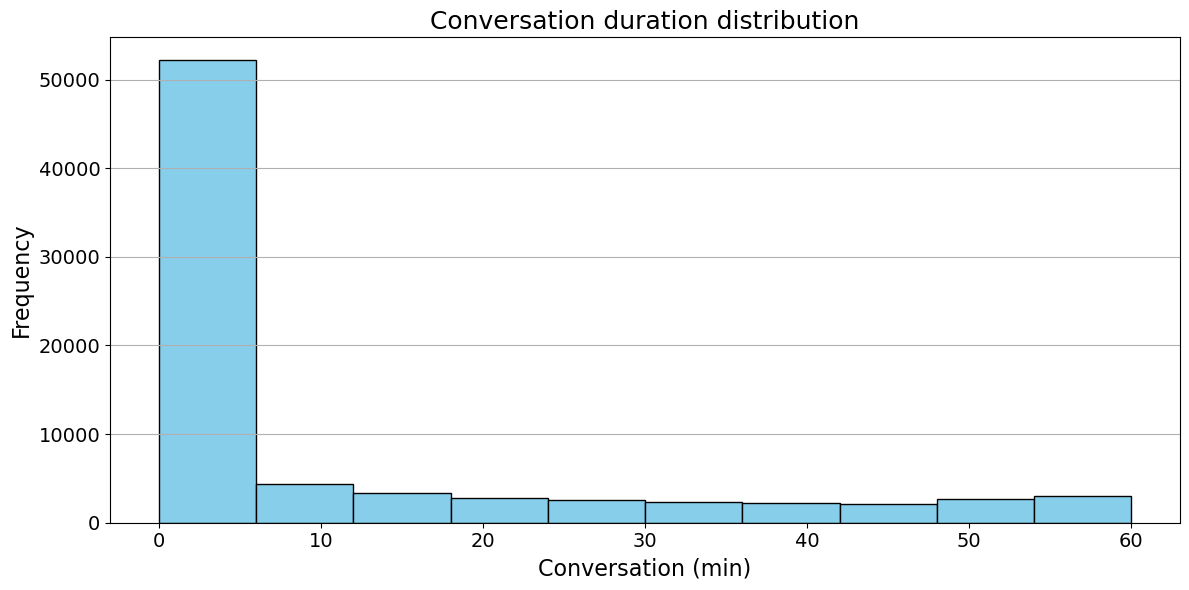

In [140]:
# Plot
plt.figure(figsize=(12, 6))
conversation_df['duration'].plot(kind='hist',bins=10,edgecolor="k" ,color='skyblue')
plt.title('Conversation duration distribution',fontsize=18)
plt.xlabel('Conversation (min)', fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.xticks(rotation=0,fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

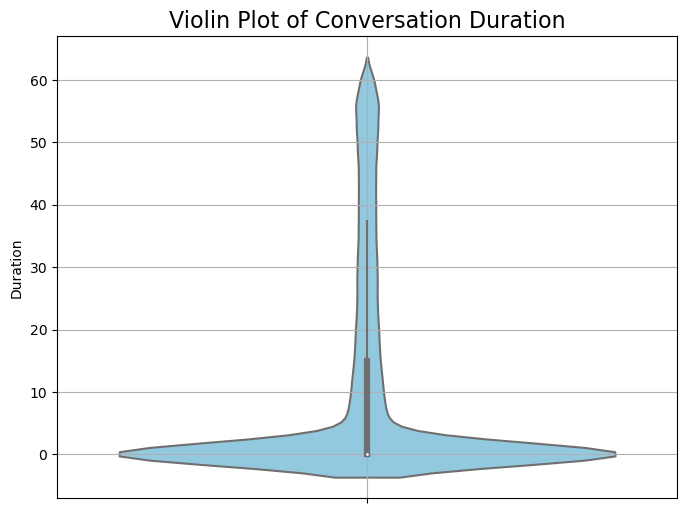

In [141]:
#MY PERSONAL VISUALIZATION
# Create a violin plot of the 'duration' column
plt.figure(figsize=(8, 6))
sns.violinplot(data=conversation_df, y='duration', color='skyblue')

plt.title('Violin Plot of Conversation Duration', fontsize=16)
plt.ylabel('Duration')

plt.grid()
plt.show()

The conversation duration distribution is highly skewed, and most values are low.

Additionally, we visualize the filtered conversation durations (during the morning hours).

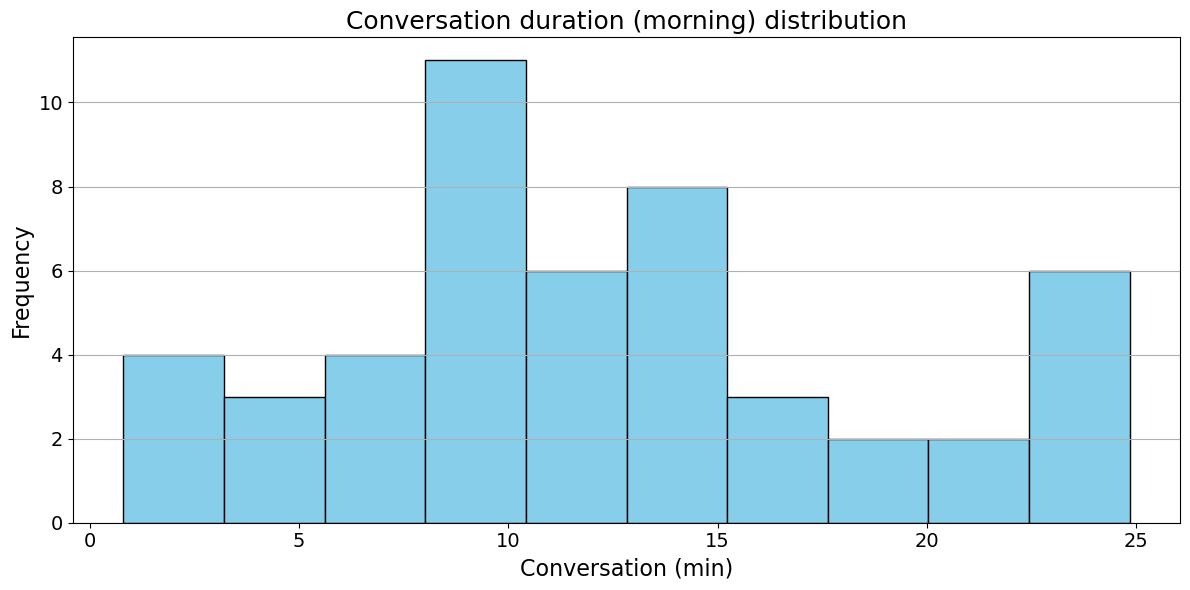

In [77]:
# Plot
plt.figure(figsize=(12, 6))
avg_conversation_df['duration'].plot(kind='hist',bins=10,edgecolor="k" ,color='skyblue')
plt.title('Conversation duration (morning) distribution',fontsize=18)
plt.xlabel('Conversation (min)', fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.xticks(rotation=0,fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In comparison with complete conversation data, the distribution here is not as skewed. 

Finally, we'll visualize conversation hourly distribution:

In [78]:
# Extract the hour from the timestamp
conversation_df['hour'] = conversation_df.index.hour

# Group by hour and sum the durations
hourly_distribution = conversation_df.groupby('hour')['duration'].sum()

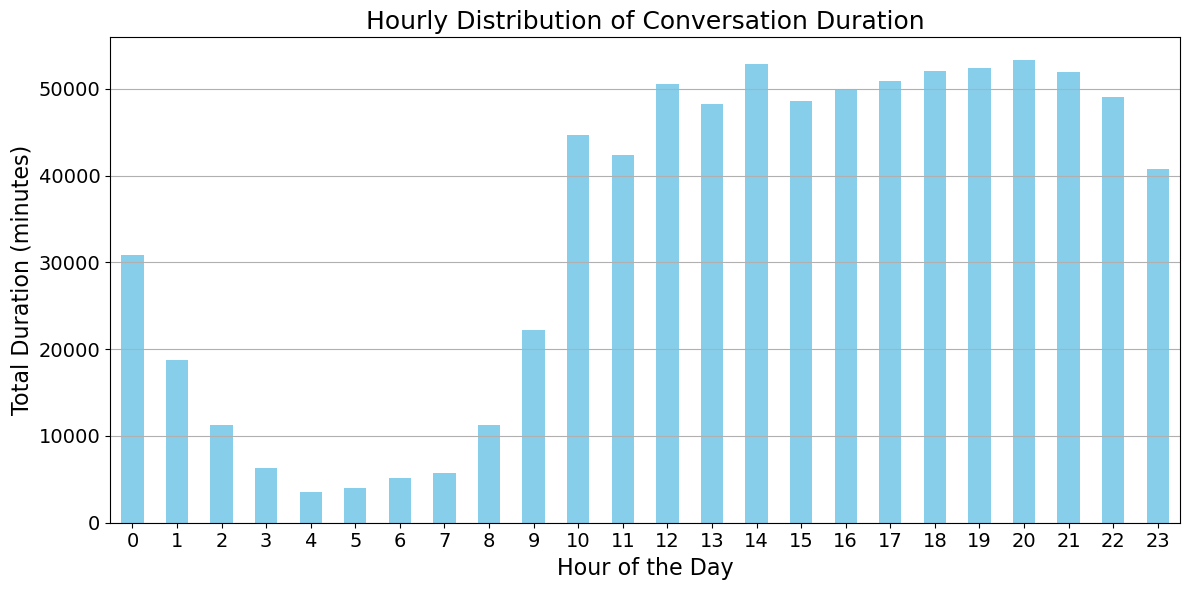

In [79]:
# Plot
plt.figure(figsize=(12, 6))
hourly_distribution.plot(kind='bar', color='skyblue')
plt.title('Hourly Distribution of Conversation Duration',fontsize=18)
plt.xlabel('Hour of the Day',fontsize=16)
plt.ylabel('Total Duration (minutes)',fontsize=16)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

Conversation duration distribution looks similar to activity distribution.

---

# Section 4: Analysis <a class="anchor" id="section_4"></a>

This section aims to analyze the relationships between different data sets to draw meaningful conclusions. Specifically, we will:

1. **Merge Dataframes:** Combine different data sources for a unified view.
2. **Visualize Data:** Use graphs to understand trends and distributions.
3. **Regression Analysis:** Calculate correlations to interpret the relationships between variables.

## Section 4.1: Merge dataframes <a class="anchor" id="section_4_1"></a>

First, we must merge the relevant dataframes to perform a comprehensive analysis by aligning them with their common 'id' fields.

First, join **the conversion duration dataframe** with **the grades dataframe.**

&#x1F4DD; **Task:**
- merge dataframes "avg_conversation_df" and "grades_df" using pandas [`pandas.DataFrame.merge()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html)
- merge on columns named "id" and use "inner" join
- &#x1F4A1; use parameters:
   - left_on = ...
   - right_on = ...
   - how = ...

In [145]:
merged_conversation = avg_conversation_df.merge(grades_df, left_on='id', \
                                      right_on='id', how='inner')
merged_conversation.head()

,id,duration,gpa
0,u01,13.368624,1.777778
1,u02,16.726136,4.000000
2,u04,24.844192,3.500000
3,u05,16.377904,3.777778
4,u07,8.444949,4.000000


Next, merge **the activity duration dataframe** with **the grades dataframe.**

&#x1F4DD; **Task:**
- merge dataframes "avg_activity_df" and "grades_df" using pandas [`pandas.DataFrame.merge()`]
- use the same parameters as in the previous step

In [146]:
# Assuming you have a dataframe 'grades_df' with 'id' and 'gpa all' columns

merged_activity = avg_activity_df.merge(grades_df, left_on='id', \
                                  right_on='id', how='inner')

merged_activity.head()

,id,duration,gpa
0,u01,0.072225,1.777778
1,u02,0.081922,4.000000
2,u04,0.122009,3.500000
3,u05,0.057836,3.777778
4,u07,0.056255,4.000000


Merging will give us two new dataframes, `merged_conversation`, and `merged_activity`, which we will use for further analysis.

## Section 4.2: Visualize data <a class="anchor" id="section_4_2"></a>

### 4.2.1. GPA and activity duration <a class="anchor" id="section_4_2_1"></a>

Using a scatter plot, we can visualize the linear relationship between GPA and average activity duration.

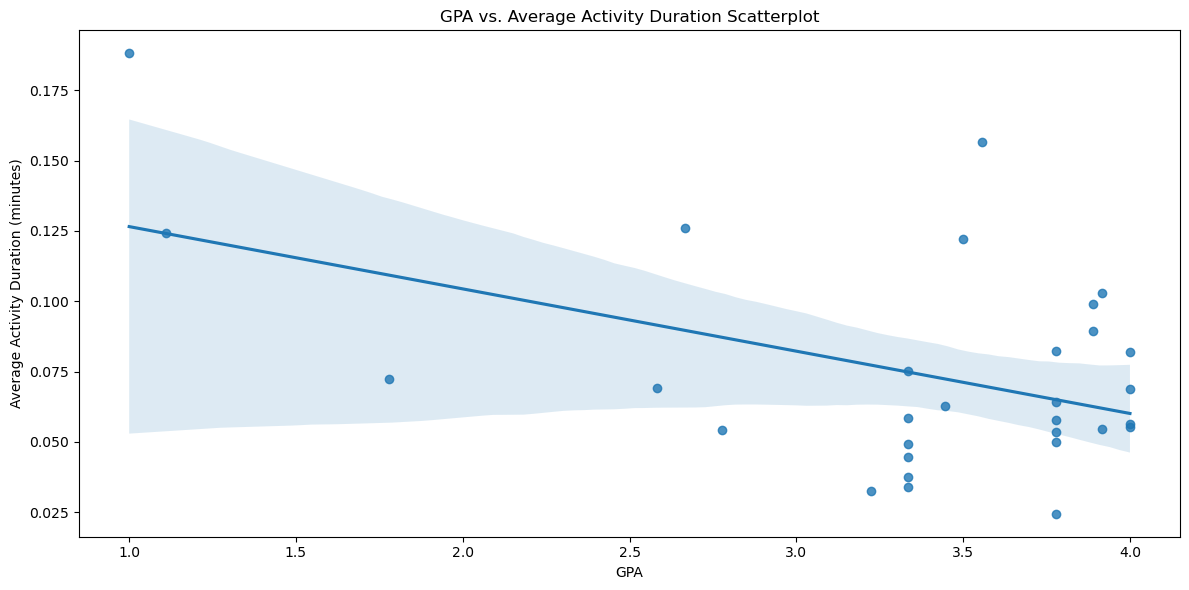

In [149]:
# Plot
plt.figure(figsize=(12, 6))
sns.regplot(data=merged_activity, x="gpa", y="duration")
plt.title('GPA vs. Average Activity Duration Scatterplot')
plt.xlabel('GPA')
plt.ylabel('Average Activity Duration (minutes)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 4.2.2. GPA and conversation duration <a class="anchor" id="section_4_2_2"></a>

Similarly, we can visualize the linear relationship between GPA and average conversation duration.

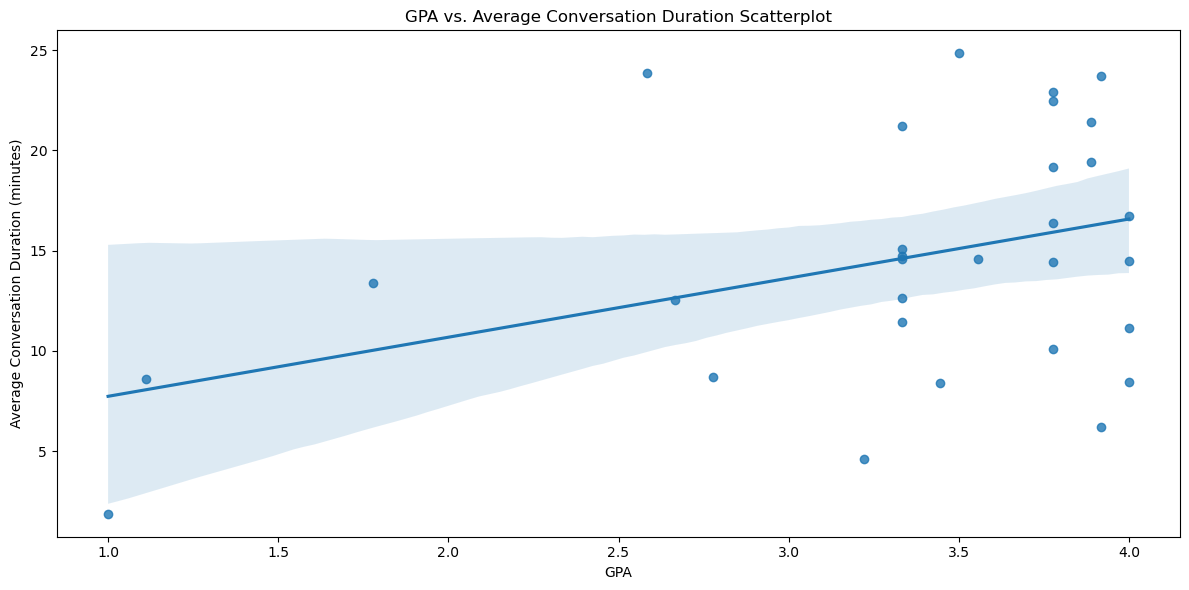

In [150]:
# Plot
plt.figure(figsize=(12, 6))
sns.regplot(data=merged_conversation, x="gpa", y="duration")
plt.title('GPA vs. Average Conversation Duration Scatterplot')
plt.xlabel('GPA')
plt.ylabel('Average Conversation Duration (minutes)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Section 4.3: Regression Analysis <a class="anchor" id="section_4_3"></a>

Regression analysis is a set of statistical processes used for modeling and analyzing the relationships between a dependent variable and one or more independent variables. By adjusting one independent variable, we can observe and analyze the corresponding changes in the dependent variable. In this exercise, we use `scipy.stats` library already imported as "stats". 

### Section 4.3.1: GPA vs Activity Duration <a class="anchor" id="section_4_3_1"></a>

To examine the correlation between GPA and average activity duration, we will use Pearson's correlation coefficient.

&#x1F4DD; **Task:**
- Calculate Pearson's correlation coefficient and corresponding p-value between "duration" and "gpa" from `merged_activity` dataframe, using [`scipy.stats.pearsonr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)
- Assign correlation coefficient to "correlation" and p-value to "p_value"

In [151]:
from scipy.stats import pearsonr

In [152]:
# Calculate Pearson's correlation coefficient and p-value
correlation, p_value = pearsonr(merged_activity['duration'], merged_activity['gpa'])
print(f"Correlation: {correlation}, P-value: {p_value}")

Correlation: -0.4703087936974372, P-value: 0.008724253212447262


### Section 4.3.2: GPA vs Conversation Duration <a class="anchor" id="section_4_3_2"></a>

Similarly, we'll look at the correlation between GPA and conversation duration.

&#x1F4DD; **Task:**
- Calculate Pearson's correlation coefficient (and corresponding p-value) between "duration" and "gpa" from "merged_conversation" dataframe, using [`scipy.stats.pearsonr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)
- Assign correlation coefficient to "correlation" and p-value to "p_value"

In [157]:
# YOUR CODE HERE
correlation, p_value = pearsonr(merged_conversation['duration'],merged_conversation['gpa'])
print(f"Correlation: {correlation}, P-value: {p_value}")

Correlation: 0.3859224674896364, P-value: 0.03517441397170433


---

# Section 5: Interpretation  <a class="anchor" id="section_5"></a>

Now, let's have a closer look at the results in the previous section and answer the following multiple-choice questions:

## Multiple Choice Questions

### Question 1
**What does a negative correlation coefficient indicate about the relationship between two variables?**
- A: The variables are unrelated.
- B: The variables are negatively correlated.
- C: The correlation coefficient alone does not indicate the direction of the relationship.
- D: The variables are positively correlated.

---

### Question 2
**What can be inferred from a p-value for the correlation between students' average activity and academic performance?**
- A: The p-value alone cannot determine the significance of the correlation.
- B: The correlation is weak.
- C: The correlation is not statistically significant.
- D: The correlation is statistically significant.

---

### Question 3
**What does a correlation coefficient between students' average activity and academic performance suggest?**
- A: No correlation.
- B: A moderate negative correlation.
- C: A very strong negative correlation.
- D: A weak negative correlation.

---

### Question 4
**What can be inferred about students' engagement in discussions during morning hours (9 a.m. to noon) and their academic performance?**
- A: They are positively correlated.
- B: They are unrelated.
- C: Cannot be determined.
- D: They are negatively correlated.

---

### Question 5
**What does a p-value of for the correlation between students' morning discussions and academic performance indicate?**
- A: The correlation is very strong.
- B: The p-value alone cannot determine the significance of the correlation.
- C: The correlation is statistically significant.
- D: The correlation is not statistically significant.

---

📝 **Task:**
- Answer the question by adding the right choices ("A", "B", ''C", or "D") in the following code cell after question names.
- Please do not change the question names!

In [1]:
# Your answer here. For example, if you choose option A for question 1, write: answer_1 = 'A'
answer_1 = "B"
answer_2 = "D"
answer_3 = "B"
answer_4 = "A"
answer_5 = "C"

In [ ]:
### Hidden tests


In [ ]:
### Hidden tests


In [ ]:
### Hidden tests


In [ ]:
### Hidden tests


In [ ]:
### Hidden tests


---

# References <a class="anchor" id="references"></a>

[1] Wang, R., Chen, F., Chen, Z., Li, T., Harari, G., Tignor, S., ... & Campbell, A. T. (2014, September). StudentLife: assessing mental health, academic performance and behavioral trends of college students using smartphones. In Proceedings of the 2014 ACM international joint conference on pervasive and ubiquitous computing (pp. 3-14).https://doi.org/10.1145/2632048.2632054

---

# *Extra Reading: Notes on Pearson Correlation Assumptions and Assessment <a class="anchor" id="extra"></a>

## What is Pearson Correlation?

Pearson correlation is a statistical measure for assessing the strength and direction of a linear relationship between two numerical variables. However, certain assumptions must be met to ensure the results are reliable.

---

## Assumptions for Pearson Correlation:

1. **Linearity**: The relationship between the two variables should be linear.
2. **Normality**: Both variables should be normally distributed, especially for small sample sizes.
3. **Homoscedasticity**: The variability of one variable should be consistent across the range of the second variable.
4. **No Outliers**: Outliers can skew the results and should be avoided.
5. **Independence**: Each pair of observations should be independent of each other.
6. **Scale of Measurement**: Variables should be measured on either an interval or ratio scale.

---
## How to Assess These Assumptions:

### 1. Linearity
- **How to Check**: Use scatterplots to assess the two variables' linearity visually.
- **What to Look For**: A roughly straight-line pattern in the scatterplot.

### 2. Normality
- **How to Check**: Use histograms, Q-Q (Quantile-Quantile) plots, or statistical tests like the Shapiro-Wilk test.
- **What to Look For**: In histograms, a bell-shaped curve. In Q-Q plots, the points should lie along the diagonal line.

### 3. Homoscedasticity
- **How to Check**: Examine scatterplots.
- **What to Look For**: A consistent spread of residuals (difference between observed and predicted values) across all independent variable levels.

### 4. No Outliers
- **How to Check**: Scatterplots, Z-scores, or specialized tests for outliers.
- **What to Look For**: Points that deviate significantly from the scatterplot general pattern. Z-scores greater than 3 or less than -3 are often considered outliers.

### 5. Independence
- **How to Check**: This is usually more related to study design than something that can be checked after data collection.
- **What to Look For**: Ensure that the data collection process guarantees that each data point is independent.

### 6. Scale of Measurement
- **How to Check**: Examine the variables and the context in which they are measured.

---

By understanding and checking these assumptions, you can interpret Pearson correlation results more accurately and meaningfully.